# Introduction

In source separation, the goal is to be able to separate out the sources from an observed mixture signal which consists of superposition of several sources. Let us demonstrate this with an example. 

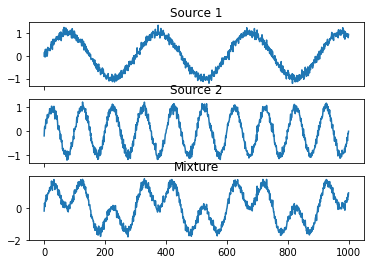

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

T = 1000
t = np.arange(0, T)
fs = 3000
f0 = 10

source1 = np.sin(2*np.pi*(f0/fs)*t) + 0.1*np.random.randn(T)
source2 = np.sin(2*np.pi*(3*f0/fs)*t)+ 0.1*np.random.randn(T)
mixture = source1 + source2

plt.subplot(311)
plt.plot(source1)
plt.title('Source 1')
plt.xticks(np.arange(0, 100, T), '')

plt.subplot(312)
plt.plot(source2)
plt.title('Source 2')
plt.xticks(np.arange(0, 100, T), '')

plt.subplot(313)
plt.plot(mixture)
plt.title('Mixture')
plt.show()

The goal is to get Source 1 and Source 2 from the Mixture Signal. In our case Source 1 is a noisy sinosoid with frequency f0, and Source is a noisy sinusoid with frequency 3*f0.  

# A toy example

Now, let's consider a slightly more interesting case where, source 1 is a sinusoid with a random frequency smaller than f_threshold, and source 2 is a sinusoid with frequency larger than f_threshold. Let's first build the dataset and and the dataloaders using speechbrain. We will then build a model which will able to separate out the sources successfully. 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:472: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:664.)
  normalized, onesided, return_complex)


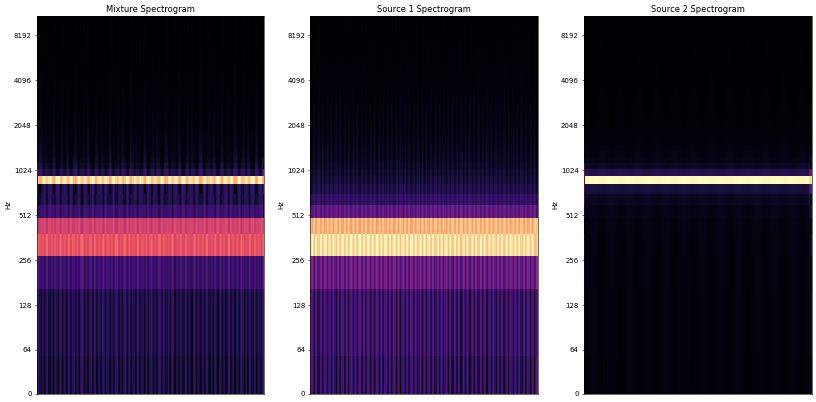

In [ ]:
import torch
import torch.utils.data as data_utils 
import librosa.display as lrd

N = 100
f_th = 200
fs = 8000

T = 10000
t = torch.arange(0, T).unsqueeze(0)
f1 = torch.randint(5, f_th, (N, 1))
f2 = torch.randint(f_th, 400, (N, 1))
batch_size = 10

source1 = torch.sin(2*np.pi*(f1/fs)*t)
source2 = torch.sin(2*np.pi*(f2/fs)*t)
mixture = source1 + source2
N_train = 90

train_dataset = data_utils.TensorDataset(source1[:N_train], source2[:N_train], mixture[:N_train])
test_dataset = data_utils.TensorDataset(source1[N_train:], source2[N_train:], mixture[N_train:]) 

train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size)

# now let's visualize the frequency spectra for the dataset
fft_size = 200

plt.figure(figsize=[20, 10], dpi=50)

plt.subplot(131)
mix_gt = mixture[N_train]
mix_spec = torch.sqrt((torch.stft(mix_gt, n_fft=fft_size)**2).sum(-1))
lrd.specshow(mix_spec.numpy(), y_axis='log')
plt.title('Mixture Spectrogram')

plt.subplot(132)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.stft(source1_gt, n_fft=fft_size)**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Source 1 Spectrogram')

plt.subplot(133)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.stft(source2_gt, n_fft=fft_size)**2).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Source 2 Spectrogram')

plt.show()


Now that we created the dataset, we can now focus on building a model would be able to recover the original sources from the mixture signal. For this, we will use speechbrain. Let us first install speechbrain. 

In [ ]:
%%capture
!pip install speechbrain

Now, let us construct a simple model with pytorch and speechbrain for source separation. 

In [ ]:
import speechbrain as sb
import torch.nn as nn      

# define the model
class simpleseparator(nn.Module):
  def __init__(self, fft_size, hidden_size, num_sources=2):
    super(simpleseparator, self).__init__()
    self.masking = nn.LSTM(input_size=fft_size//2 + 1, hidden_size=hidden_size, batch_first=True, bidirectional=True)
    self.output_layer = nn.Linear(in_features=hidden_size*2, out_features=num_sources*(fft_size//2 + 1))
    self.fft_size=fft_size
    self.num_sources = num_sources

  def forward(self, inp):
    # batch x freq x time x realim
    y = torch.stft(inp, n_fft=self.fft_size)
    
    # batch X freq x time
    mag = torch.sqrt((y ** 2).sum(-1))
    phase = torch.atan2(y[:, :, :, 1], y[:, :, :, 0])

    # batch x time x freq
    mag = mag.permute(0, 2, 1)

    # batch x time x feature
    rnn_out = self.masking(mag)[0]

    # batch x time x (nfft*num_sources)
    lin_out = self.output_layer(rnn_out)
    
    # batch x time x nfft x num_sources
    lin_out = nn.functional.relu(lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources))

    # reconstruct in time domain
    sources = []
    all_masks = []
    for n in range(self.num_sources):
      sourcehat_mask = (lin_out[:, :, :, n])
      all_masks.append(sourcehat_mask)

      # multiply with mask and magnitude 
      sourcehat_dft = (sourcehat_mask * mag).permute(0, 2, 1) * torch.exp(1j * phase)

      # reconstruct in time domain with istft
      sourcehat = torch.istft(sourcehat_dft, n_fft=self.fft_size)
      sources.append(sourcehat)
    return sources, all_masks, mag

# test_forwardpass
model = simpleseparator(fft_size=fft_size, hidden_size=300)
est_sources, _, _ = model.forward(mixture[:5])

Now that our model, we can now write the Brain class for training. 


In [ ]:
class SeparationBrain(sb.Brain):
    def __init__(self, train_loss, modules, opt_class):
        super(SeparationBrain, self).__init__(modules=modules, opt_class=opt_class)
        self.train_loss = train_loss

    def compute_forward(self, mix):
        """Forward computations from the mixture to the separated signals."""

        # Get the estimates for the sources 
        est_sources, _, _ = self.modules.mdl(mix)

        est_sources = torch.stack(est_sources, dim=-1)

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_sources.size(1)
        if T_origin > T_est:
            est_sources = nn.functional.pad(est_sources, (0, 0, 0, T_origin - T_est))
        else:
            est_sources = est_sources[:, :T_origin, :]

        return est_sources

    def compute_objectives(self, targets, est_sources):
        """Computes the loss functions between estimated and ground truth sources"""
        if self.train_loss == 'l1':
          return (est_sources - targets).abs().mean()
        elif self.train_loss == 'si-snr':
          return sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources).mean()


    def fit_batch(self, batch):
        """Trains one batch"""
        # Unpacking batch list
        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)
        loss = self.compute_objectives(targets, est_sources)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for test batches"""

        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)

        si_snr = sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources)
        si_snr_mean = si_snr.mean().item()
        print('VALID SI-SNR = {}'.format(-si_snr_mean))
        return si_snr.mean().detach()


from functools import partial

optimizer = lambda x: torch.optim.Adam(x, lr=0.0001)
N_epochs = 10
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='l1',
        modules={'mdl': model},
        opt_class=optimizer
        
    )


separator.fit(
            epoch_counter,
            train_loader,
            test_loader)


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


VALID SI-SNR = 5.771725654602051


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


VALID SI-SNR = 9.002069473266602


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


VALID SI-SNR = 12.797195434570312


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


VALID SI-SNR = 14.838861465454102


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


VALID SI-SNR = 16.186227798461914


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


VALID SI-SNR = 16.745651245117188


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


VALID SI-SNR = 17.103910446166992


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


VALID SI-SNR = 17.360980987548828


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


VALID SI-SNR = 17.518341064453125


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

VALID SI-SNR = 17.6535701751709


Now, let's visualize the results. For this purpose let's first install librosa. It has a nice tool for visualizing spectrograms.  




In [ ]:
%%capture
!pip install librosa 


We will first plot the the spectra for the ground truth sources. And then we will run a forward pass with the model and plot the estimated sources. 

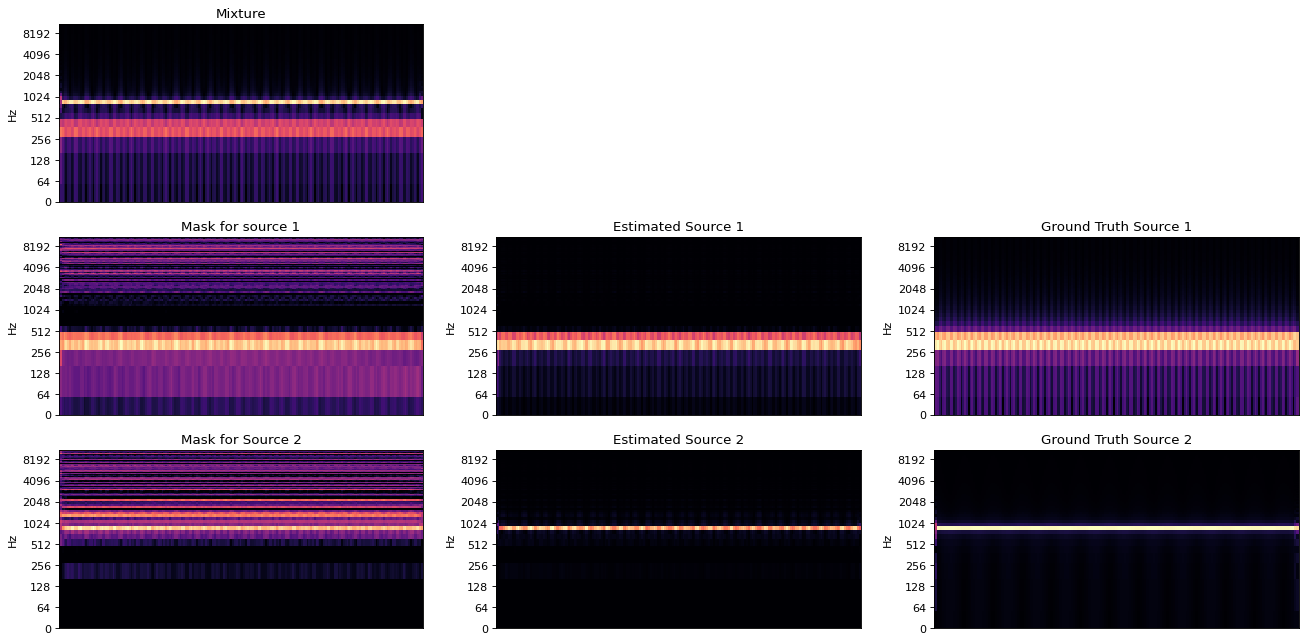

In [ ]:
estimated_sources, all_masks, mag = separator.modules.mdl.forward(mixture[N_train:])


plt.figure(figsize=[20, 10], dpi=80)

plt.subplot(331)
mag = mag[0].t().numpy()
lrd.specshow(mag, y_axis='log')
plt.title('Mixture')

plt.subplot(334)
mask1 = all_masks[0][0].detach().t().numpy()
lrd.specshow(mask1, y_axis='log')
plt.title('Mask for source 1')

plt.subplot(335)
masked1 = mask1 * mag
lrd.specshow(masked1, y_axis='log')
plt.title('Estimated Source 1')

plt.subplot(336)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.stft(source1_gt, n_fft=fft_size)**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 1')

plt.subplot(337)
mask2 = all_masks[1][0].detach().t().numpy()
lrd.specshow(mask2, y_axis='log')
plt.title('Mask for Source 2')

plt.subplot(338)
masked2 = mask2 * mag
lrd.specshow(masked2, y_axis='log')
plt.title('Estimated Source 2')

plt.subplot(339)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.stft(source2_gt, n_fft=fft_size)**2).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 2')

plt.show()


Notice that these masks are basically band stop filters which aims to remove the interferences from the other source. 

## Exercises: 

* Train the same model with SI-SNR loss and observe if this helps to improve the performance. 
* Replace the STFT front end, and the ISTFT reconstruction with convolutional layer, and transposed convolution layers. Do the same visualization above, also visualize the filters learnt by the convolutional front end, and the reconstruction layer, and compare it with the DFT bases.  


# A sound source separation example with a pre-existing model from speechbrain

First, let's download the dataset. 

In [ ]:
%%capture
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AADx5I8oV0IdekCf80MSkxMia/mixture_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAZI7ZezKyHFGPdus6hn2v_a/mixture_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACh4Yy4H-Ii2I0mr_b1lQdXa/mixture_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAenTlEsoj1-AGbCxeJfMHoa/mixture_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC-awQo-9NFVVULuVwaHKKWa/source1_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABVKWtdVhXZE6Voq1I_c6g5a/source1_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC9EfjTTwL0dscH16waP9s-a/source1_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC5Ozb4rS9qby268JSIy5Uwa/source1_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABlonG910Ms2l-rTN5ct3Oka/source2_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACDOqEgyXIeA2r1Rkf7VgQTa/source2_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACTYGAG0LOh6HvxpVYoqO_Da/source2_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACPmq-ZJNzfh4bnO34_8mfAa/source2_3.wav

Now let's first listen to these sounds. 

In [ ]:
import speechbrain
from speechbrain.dataio.dataio import read_audio
from IPython.display import Audio

mixture_0 = read_audio('mixture_0.wav').squeeze()
source1_0 = read_audio('source1_0.wav').squeeze()
source2_0 = read_audio('source2_0.wav').squeeze()

mixture_1 = read_audio('mixture_1.wav').squeeze()
source1_1 = read_audio('source1_1.wav').squeeze()
source2_1 = read_audio('source2_1.wav').squeeze()

mixture_2 = read_audio('mixture_2.wav').squeeze()
source1_2 = read_audio('source1_2.wav').squeeze()
source2_2 = read_audio('source2_2.wav').squeeze()

mixture_3 = read_audio('mixture_3.wav').squeeze()
source1_3 = read_audio('source1_3.wav').squeeze()
source2_3 = read_audio('source2_3.wav').squeeze()

train_mixs = [mixture_0, mixture_1, mixture_2]
train_source1s = [source1_0, source1_1, source1_2]
train_source2s = [source2_0, source2_1, source2_2]

Audio(mixture_0, rate=16000)

In [ ]:
Audio(source1_0, rate=16000)

In [ ]:
Audio(source2_0, rate=16000)


Now, let's construct the datasets and dataloaders. 

In [ ]:
from torch.utils.data import Dataset, DataLoader


class source_separation_dataset(Dataset):
    def __init__(self, train_mixs, train_source1s, train_source2s):
        self.mixs = train_mixs
        self.train_source1s = train_source1s
        self.train_source2s = train_source2s

    def __len__(self):
        return len(self.mixs)

    def __getitem__(self, idx):
        mix = self.mixs[idx]
        source1 = self.train_source1s[idx]
        source2 = self.train_source2s[idx]
        return mix, source1, source2

train_dataset_audio = source_separation_dataset(train_mixs, train_source1s, train_source2s)
valid_dataset_audio = source_separation_dataset([mixture_2], [source1_2], [source2_2])

train_loader_audio = DataLoader(train_dataset_audio, batch_size=1)
valid_loader_audio = DataLoader(valid_dataset_audio, batch_size=1)


And now, let's tinker the model we constructed and use it on this small dataset. For this purpose we will use the mask-based end-to-end architecture: 

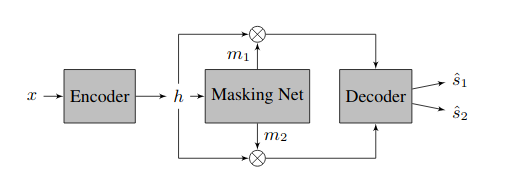




In [ ]:
fft_size=1024
model_audio = simpleseparator(fft_size=fft_size, hidden_size=300)


optimizer = lambda x: torch.optim.Adam(x, lr=0.0005)
N_epochs = 100
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='si-snr',
        modules={'mdl': model_audio},
        opt_class=optimizer
        
    )


separator.fit(
            epoch_counter,
            train_loader_audio,
            valid_loader_audio)



100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


VALID SI-SNR = -22.27044105529785


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


VALID SI-SNR = -20.258996963500977


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


VALID SI-SNR = -19.19606590270996


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


VALID SI-SNR = -18.242876052856445


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


VALID SI-SNR = -17.02764892578125


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


VALID SI-SNR = -15.91640853881836


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


VALID SI-SNR = -14.931843757629395


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


VALID SI-SNR = -14.252034187316895


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


VALID SI-SNR = -13.677473068237305


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


VALID SI-SNR = -12.990802764892578


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


VALID SI-SNR = -12.523418426513672


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


VALID SI-SNR = -12.198333740234375


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


VALID SI-SNR = -11.819523811340332


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


VALID SI-SNR = -11.419384002685547


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


VALID SI-SNR = -10.913382530212402


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


VALID SI-SNR = -10.45999526977539


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


VALID SI-SNR = -10.109785079956055


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


VALID SI-SNR = -9.73050594329834


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


VALID SI-SNR = -9.41502571105957


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


VALID SI-SNR = -9.085074424743652


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


VALID SI-SNR = -8.79912281036377


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


VALID SI-SNR = -8.469143867492676


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


VALID SI-SNR = -8.189397811889648


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


VALID SI-SNR = -7.953136920928955


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


VALID SI-SNR = -7.813356399536133


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


VALID SI-SNR = -7.525785446166992


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


VALID SI-SNR = -7.279414176940918


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


VALID SI-SNR = -7.20250129699707


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


VALID SI-SNR = -6.969470500946045


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


VALID SI-SNR = -6.630548000335693


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


VALID SI-SNR = -6.432660102844238


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


VALID SI-SNR = -6.249157428741455


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


VALID SI-SNR = -6.0653791427612305


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


VALID SI-SNR = -5.848248481750488


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


VALID SI-SNR = -5.678573131561279


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


VALID SI-SNR = -5.522701263427734


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


VALID SI-SNR = -5.4054388999938965


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


VALID SI-SNR = -5.26059627532959


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


VALID SI-SNR = -5.1135969161987305


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


VALID SI-SNR = -4.972296237945557


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


VALID SI-SNR = -4.8644609451293945


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


VALID SI-SNR = -4.735635757446289


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


VALID SI-SNR = -4.652956008911133


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


VALID SI-SNR = -4.532505035400391


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


VALID SI-SNR = -4.476442813873291


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


VALID SI-SNR = -4.603140354156494


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


VALID SI-SNR = -4.555534362792969


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


VALID SI-SNR = -4.390381813049316


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


VALID SI-SNR = -4.3891401290893555


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


VALID SI-SNR = -4.260599136352539


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


VALID SI-SNR = -4.231424331665039


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


VALID SI-SNR = -4.247060298919678


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


VALID SI-SNR = -4.1851935386657715


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


VALID SI-SNR = -4.104639530181885


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


VALID SI-SNR = -4.086826324462891


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


VALID SI-SNR = -3.9924092292785645


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


VALID SI-SNR = -4.039332389831543


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


VALID SI-SNR = -4.003710746765137


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


VALID SI-SNR = -3.945643663406372


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


VALID SI-SNR = -3.92105770111084


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


VALID SI-SNR = -3.8742027282714844


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


VALID SI-SNR = -3.826356887817383


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


VALID SI-SNR = -3.924565076828003


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


VALID SI-SNR = -3.897876024246216


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


VALID SI-SNR = -4.03639030456543


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


VALID SI-SNR = -4.011552810668945


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


VALID SI-SNR = -3.9583873748779297


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


VALID SI-SNR = -3.957021713256836


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


VALID SI-SNR = -3.957900047302246


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


VALID SI-SNR = -4.1473259925842285


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


VALID SI-SNR = -3.9398927688598633


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


VALID SI-SNR = -3.958892822265625


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


VALID SI-SNR = -4.139433860778809


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


VALID SI-SNR = -4.075671672821045


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


VALID SI-SNR = -4.731243133544922


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


VALID SI-SNR = -4.1817216873168945


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


VALID SI-SNR = -4.7978715896606445


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


VALID SI-SNR = -4.668816089630127


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


VALID SI-SNR = -4.470100402832031


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


VALID SI-SNR = -4.277880668640137


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


VALID SI-SNR = -3.9983863830566406


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


VALID SI-SNR = -4.031136989593506


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


VALID SI-SNR = -4.0282793045043945


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


VALID SI-SNR = -3.98183274269104


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


VALID SI-SNR = -3.9946017265319824


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


VALID SI-SNR = -3.9612460136413574


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


VALID SI-SNR = -3.8708438873291016


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


VALID SI-SNR = -3.793203592300415


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


VALID SI-SNR = -3.8361401557922363


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


VALID SI-SNR = -3.868450880050659


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


VALID SI-SNR = -3.79771089553833


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


VALID SI-SNR = -3.6870980262756348


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


VALID SI-SNR = -3.6620850563049316


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


VALID SI-SNR = -3.6149353981018066


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


VALID SI-SNR = -3.646519660949707


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


VALID SI-SNR = -3.6116623878479004


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


VALID SI-SNR = -3.756805419921875


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


VALID SI-SNR = -3.621781826019287


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


VALID SI-SNR = -3.5634117126464844


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

VALID SI-SNR = -3.50610089302063


In [ ]:
class audioseparator(nn.Module):
  def __init__(self, fft_size, hidden_size, num_sources=2, kernel_size=16):
    super(audioseparator, self).__init__()
    self.encoder = nn.Conv1d(in_channels=1, out_channels=fft_size, kernel_size=16, stride=kernel_size//2)
    
    # MaskNet
    self.rnn = nn.LSTM(input_size=fft_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
    self.output_layer = nn.Linear(in_features=hidden_size*2, out_features=num_sources*(fft_size))

    self.decoder = nn.ConvTranspose1d(in_channels=fft_size, out_channels=1, kernel_size=kernel_size, stride=kernel_size//2)

    self.fft_size = fft_size
    self.hidden_size = hidden_size
    self.num_sources = num_sources

  def forward(self, inp):
    # batch x channels x time
    y = nn.functional.relu(self.encoder(inp.unsqueeze(0)))

    # batch x time x nfft
    y = y.permute(0, 2, 1)

    # batch x time x feature
    rnn_out = self.rnn(y)[0]

    # batch x time x (nfft*num_sources)
    lin_out = self.output_layer(rnn_out)
    
    # batch x time x nfft x num_sources
    lin_out = lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources)

    # reconstruct in time domain
    sources = []
    all_masks = []
    for n in range(self.num_sources):
      sourcehat_mask = nn.functional.relu(lin_out[:, :, :, n])
      all_masks.append(sourcehat_mask)

      # multiply with mask and magnitude 
      T = sourcehat_mask.size(1)
      sourcehat_latent = (sourcehat_mask * y[:, :T, :]).permute(0, 2, 1)

      # reconstruct in time domain with istft
      sourcehat = self.decoder(sourcehat_latent).squeeze(0)
      sources.append(sourcehat)

    return sources, all_masks, y

model_audio = audioseparator(fft_size=fft_size, hidden_size=300, kernel_size=256)
out, _, _ = model_audio.forward(mixture_0.unsqueeze(0))


In [ ]:
optimizer = lambda x: torch.optim.Adam(x, lr=0.0002)
N_epochs = 200
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='si-snr',
        modules={'mdl': model_audio},
        opt_class=optimizer
        
    )

separator.fit(
            epoch_counter,
            train_loader_audio,
            valid_loader_audio)


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


VALID SI-SNR = -31.17813491821289


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


VALID SI-SNR = -27.440563201904297


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -25.356300354003906


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -23.901344299316406


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


VALID SI-SNR = -22.81186294555664


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


VALID SI-SNR = -21.94656753540039


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -21.224973678588867


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


VALID SI-SNR = -20.59880828857422


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


VALID SI-SNR = -20.037761688232422


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


VALID SI-SNR = -19.50804901123047


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -18.995271682739258


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -18.49283218383789


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -18.01244354248047


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -17.54298210144043


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -17.0960750579834


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -16.657556533813477


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -16.23984146118164


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -15.830002784729004


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -15.426060676574707


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -15.033357620239258


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -14.648308753967285


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -14.281194686889648


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -13.936767578125


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -13.61971664428711


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -13.313470840454102


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -13.013434410095215


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -12.72853946685791


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -12.460188865661621


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


VALID SI-SNR = -12.20497989654541


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -11.963502883911133


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


VALID SI-SNR = -11.729194641113281


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -11.498549461364746


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -11.279605865478516


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -11.068933486938477


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -10.86236572265625


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -10.662062644958496


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -10.4649076461792


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -10.277727127075195


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


VALID SI-SNR = -10.091280937194824


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -9.910842895507812


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -9.734312057495117


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -9.560215950012207


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


VALID SI-SNR = -9.393607139587402


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


VALID SI-SNR = -9.234015464782715


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -9.06788158416748


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -8.92445182800293


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


VALID SI-SNR = -8.768878936767578


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -8.63790512084961


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -8.492437362670898


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


VALID SI-SNR = -8.362724304199219


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -8.230182647705078


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


VALID SI-SNR = -8.105229377746582


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -7.977020263671875


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -7.855387210845947


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -7.739683628082275


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -7.623241424560547


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


VALID SI-SNR = -7.518948554992676


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -7.415074348449707


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -7.3128790855407715


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -7.206343650817871


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


VALID SI-SNR = -7.108607769012451


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -7.010547161102295


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -6.918424606323242


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -6.833024501800537


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -6.7360005378723145


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -6.655050277709961


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -6.577078819274902


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


VALID SI-SNR = -6.523106575012207


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


VALID SI-SNR = -6.4353132247924805


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -6.347858428955078


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -6.32937479019165


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


VALID SI-SNR = -6.210646152496338


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


VALID SI-SNR = -6.172745704650879


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -6.060779571533203


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -6.027941703796387


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


VALID SI-SNR = -5.956303119659424


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


VALID SI-SNR = -5.892360687255859


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -5.820440292358398


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


VALID SI-SNR = -5.759784698486328


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


VALID SI-SNR = -5.703275680541992


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -5.671274662017822


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


VALID SI-SNR = -5.58042573928833


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -5.58488130569458


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -5.542583465576172


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -5.438714981079102


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -5.4285664558410645


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -5.338762283325195


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -5.309804916381836


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -5.238805294036865


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


VALID SI-SNR = -5.184526443481445


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -5.112465858459473


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


VALID SI-SNR = -5.072277545928955


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -5.029749393463135


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -4.980328559875488


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


VALID SI-SNR = -4.90636682510376


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -4.909289360046387


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


VALID SI-SNR = -4.855592250823975


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


VALID SI-SNR = -4.811840534210205


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -4.8127288818359375


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -4.7535624504089355


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


VALID SI-SNR = -4.746822834014893


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -4.752904891967773


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -4.627146244049072


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -4.65665340423584


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -4.5829997062683105


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -4.603298664093018


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


VALID SI-SNR = -4.497697353363037


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -4.544794082641602


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -4.400822639465332


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -4.368820667266846


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -4.325563430786133


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -4.2879133224487305


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -4.247821807861328


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -4.2358527183532715


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


VALID SI-SNR = -4.150256156921387


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -4.177993297576904


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


VALID SI-SNR = -4.119611740112305


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -4.093447208404541


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


VALID SI-SNR = -4.077662467956543


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


VALID SI-SNR = -4.047540664672852


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


VALID SI-SNR = -4.00892972946167


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -4.036553382873535


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -3.9718446731567383


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


VALID SI-SNR = -4.001635551452637


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


VALID SI-SNR = -3.9400734901428223


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -3.8992867469787598


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


VALID SI-SNR = -3.8777670860290527


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -3.8467230796813965


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


VALID SI-SNR = -3.824232816696167


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -3.726494789123535


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


VALID SI-SNR = -3.7823705673217773


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -3.678901433944702


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


VALID SI-SNR = -3.685793399810791


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


VALID SI-SNR = -3.6746201515197754


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -3.5892601013183594


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


VALID SI-SNR = -3.6011054515838623


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


VALID SI-SNR = -3.5198912620544434


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -3.5504231452941895


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -3.4832377433776855


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -3.4476752281188965


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


VALID SI-SNR = -3.400899887084961


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -3.4175117015838623


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


VALID SI-SNR = -3.3518896102905273


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


VALID SI-SNR = -3.320122003555298


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -3.3150463104248047


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


VALID SI-SNR = -3.2983756065368652


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


VALID SI-SNR = -3.2557497024536133


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


VALID SI-SNR = -3.25412654876709


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -3.2567710876464844


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -3.247960090637207


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


VALID SI-SNR = -3.2185921669006348


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -3.2300477027893066


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -3.2036075592041016


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -3.1878466606140137


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -3.1533522605895996


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


VALID SI-SNR = -3.0947859287261963


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -3.087717056274414


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -3.0338196754455566


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


VALID SI-SNR = -3.0580503940582275


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


VALID SI-SNR = -2.9682044982910156


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -2.952582836151123


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -2.951169967651367


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


VALID SI-SNR = -2.9514212608337402


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -2.908769369125366


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -2.8991212844848633


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


VALID SI-SNR = -2.8564348220825195


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


VALID SI-SNR = -2.823455810546875


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -2.8155150413513184


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -2.7791175842285156


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -2.7816948890686035


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -2.75467586517334


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


VALID SI-SNR = -2.7829222679138184


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -2.756805419921875


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -2.7126922607421875


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -2.7425925731658936


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -2.6563773155212402


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


VALID SI-SNR = -2.746541976928711


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


VALID SI-SNR = -2.6177783012390137


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


VALID SI-SNR = -2.679377555847168


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


VALID SI-SNR = -2.562429428100586


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


VALID SI-SNR = -2.559638500213623


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -2.4943296909332275


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


VALID SI-SNR = -2.4568448066711426


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -2.4309933185577393


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


VALID SI-SNR = -2.3863115310668945


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -2.3768820762634277


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


VALID SI-SNR = -2.3478968143463135


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -2.356537342071533


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -2.3622002601623535


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


VALID SI-SNR = -2.3448307514190674


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


VALID SI-SNR = -2.378726005554199


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


VALID SI-SNR = -2.3767805099487305


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


VALID SI-SNR = -2.349048137664795


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


VALID SI-SNR = -2.3564558029174805


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -2.293363332748413


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


VALID SI-SNR = -2.259641170501709


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -2.270047426223755


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -2.1969642639160156


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


VALID SI-SNR = -2.230203628540039


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

VALID SI-SNR = -2.1638269424438477


In [ ]:
estimated_sources_test, all_masks, mag = model_audio.forward(mixture_3.unsqueeze(0))
estimated_sources_train, all_masks, mag = model_audio.forward(mixture_0.unsqueeze(0))


Audio(estimated_sources_test[0].squeeze().detach(), rate=16000)


In [ ]:
Audio(estimated_sources_test[1].squeeze().detach(), rate=16000)


In [ ]:
Audio(estimated_sources_train[0].squeeze().detach(), rate=16000)

In [ ]:
Audio(estimated_sources_train[1].squeeze().detach(), rate=16000)

It does not work that great because of the introduced artifacts, but we can hear that it supresses the 

---

interferences. 

# **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


# **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```